<a href="https://colab.research.google.com/github/VincentNFR/openclassrooms_p06/blob/main/resnet_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

# Import des donneés

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
convert_labels = {0: 'afghan_hound', 1: 'maltese_dog', 2: 'pomeranian', 3: 'samoyed', 4: 'scottish_deerhound'}

In [4]:
# Save train
X_train = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/X_train.npy', allow_pickle=True)
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/y_train.npy', allow_pickle=True)
# Save validation
X_val = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/X_val.npy', allow_pickle=True)
y_val = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/y_val.npy', allow_pickle=True)
# Save test
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/X_test.npy', allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/y_test.npy', allow_pickle=True)

In [5]:
X_train.shape, X_val.shape, X_test.shape

((1749, 224, 224, 3), (375, 224, 224, 3), (376, 224, 224, 3))

In [6]:
y_train.shape, y_val.shape, y_test.shape

((1749, 5), (375, 5), (376, 5))

# Evaluation des modèles

In [7]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix\n for the class\n" + class_label)

def get_confusion_matrix(y_test, y_pred):
    m = multilabel_confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8,12), facecolor='white')
    fig, ax = plt.subplots(1, 5, figsize=(12, 4))
    for i, [axes, cfs_matrix] in enumerate(zip(ax.flatten(), m)):
        print_confusion_matrix(cfs_matrix, axes, convert_labels[i], ["0", "1"])

    fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    return fig


def evaluate_model(model, X_test, y_test, convert_labels):
    ### Predict
    y_pred = np.zeros((X_test.shape[0], 5))
    for y in range(y_pred.shape[0]):
        y_pred[y, np.argmax(model.predict(np.expand_dims(X_test[y], axis=0)))] = 1
    ### Confusion Matrix
    get_confusion_matrix(y_test, y_pred).show()
    ### Scores
    print('\n\n')
    print(classification_report(y_test,y_pred))

# Import du modèle d'apprentissage

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

def import_model(conv_model_type, input_shape=(224, 224, 3), weights=None, train_state=True, custom_model=None, lr=1e-3):
    if custom_model is not None:
        include_top = False
    else:
        include_top = True
    if conv_model_type == 'vgg':
        conv_model = tf.keras.applications.VGG16(
        include_top=include_top,
        input_shape=input_shape,
        weights=weights,
        input_tensor=None,
        pooling=None,
        classes=5,
        classifier_activation="softmax",
        )
    else:
        conv_model = tf.keras.applications.ResNet50(
        include_top=include_top,
        weights=weights,
        input_shape=input_shape,
        input_tensor=None,
        pooling=None,
        classes=5,
        classifier_activation="softmax",
        )

    # Freeze the pretrained weights
    conv_model.trainable = train_state

    # Construction du model
    model = Sequential()
    model.add(conv_model)
    if custom_model is not None:
        model.add(custom_model)

    # Summary
    model.summary()
    conv_model.summary()
    if custom_model is not None:
        custom_model.summary()

    # Compile
    model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=lr), 
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
    )

    return model

In [9]:
## Custom model 1
configuration_1 = Sequential(
    layers=[
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.2),
            Dense(1024, activation='relu'),
            Dropout(0.2),
            Dense(5, activation='softmax')
    ],
    name = 'custom_config_1')

## Custom model 2
configuration_2 = Sequential(
    layers=[
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.2),
            Dense(1024, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(5, activation='softmax')
    ],
    name = 'custom_config_2')

## Custom model 3
configuration_3 = Sequential(
    layers=[
            Flatten(),
            Dense(4096, activation='selu'),
            Dropout(0.2),
            Dense(1024, activation='selu'),
            Dropout(0.2),
            Dense(5, activation='softmax')
    ],
    name = 'custom_config_3')

## Custom model 4
configuration_4 = Sequential(
    layers=[
            Flatten(),
            Dense(4096, activation='selu'),
            Dropout(0.2),
            Dense(1024, activation='selu'),
            Dropout(0.2),
            Dense(128, activation='selu'),
            Dropout(0.2),
            Dense(5, activation='softmax')
    ],
    name = 'custom_config_4')

In [10]:
model = import_model(conv_model_type='ResNet50', input_shape=(224, 224, 3), weights=None, train_state=True, custom_model=None, lr=1e-3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5)                 23597957  
                                                                 
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0

In [11]:
epochs = 50
batch_size = 32

history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    verbose=1
    )

Epoch 1/50
54/54 [==============================] - 60s 776ms/step - loss: 1.4079 - accuracy: 0.6465 - val_loss: 3.4222 - val_accuracy: 0.1947
Epoch 2/50
54/54 [==============================] - 39s 724ms/step - loss: 0.6807 - accuracy: 0.7402 - val_loss: 2.0213 - val_accuracy: 0.2987
Epoch 3/50
54/54 [==============================] - 39s 727ms/step - loss: 0.5880 - accuracy: 0.7666 - val_loss: 4.2309 - val_accuracy: 0.2000
Epoch 4/50
54/54 [==============================] - 39s 728ms/step - loss: 0.5471 - accuracy: 0.7991 - val_loss: 2.4159 - val_accuracy: 0.3173
Epoch 5/50
54/54 [==============================] - 39s 727ms/step - loss: 0.5602 - accuracy: 0.7946 - val_loss: 10.9850 - val_accuracy: 0.2160
Epoch 6/50
54/54 [==============================] - 40s 734ms/step - loss: 0.5521 - accuracy: 0.8070 - val_loss: 9.0007 - val_accuracy: 0.3360
Epoch 7/50
54/54 [==============================] - 39s 727ms/step - loss: 0.6481 - accuracy: 0.7565 - val_loss: 1.9522 - val_accuracy: 0.338




              precision    recall  f1-score   support

           0       0.61      0.74      0.67        66
           1       0.85      0.72      0.78        81
           2       0.82      0.79      0.81        71
           3       0.80      0.71      0.75        75
           4       0.71      0.81      0.76        83

   micro avg       0.75      0.75      0.75       376
   macro avg       0.76      0.75      0.75       376
weighted avg       0.76      0.75      0.75       376
 samples avg       0.75      0.75      0.75       376



<Figure size 576x864 with 0 Axes>

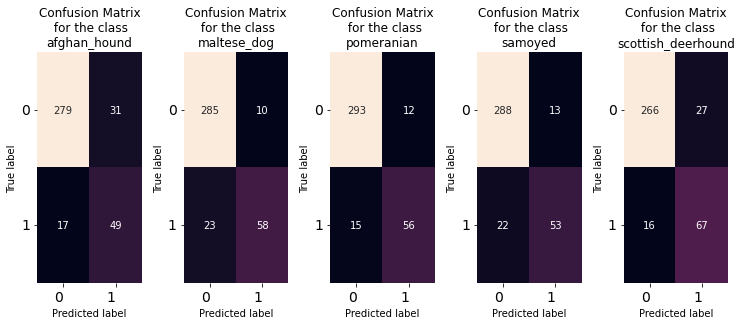

In [12]:
evaluate_model(model, X_test, y_test, convert_labels)